## Overview of gene-disease association data

This example data comes from a single database (DisGeNET): http://www.disgenet.org/web/DisGeNET/menu/home

The weighted scores described below represent a metric [0,1] that describes the quality of the established link between the identified gene and associated diseases. Each gene may influence several diseases and each diseases may be influenced by several genes. 

<i>Score = ( WUniProt + WCTDhuman + WClinVar ) + ( WRat + WMouse ) + ( WGAD + WLHGDN + WBeFree )</i>

where <i>WUniProt = 0 or 0.3, WCTDhuman = 0 or 0.3, WRat = 0 or 0.1, WMouse = 0 or 0.1, WLiterature = WGAD or WLHGDN or WBeFree and WLiterature = 0.06 for LHGDN or BeFree, and WLiterature = 0.08 for GAD</i>. If the number of publications reporting a gene-disease association in the source database (<i>n<sub>gd</sub></i>) multiplied by 100 and divided by the number of publications in the source (<i>NLiterature</i>) is less than this quotient then <i> WLiterature = (n<sub>gd</sub> * 100) / NLiterature</i> is reported instead.

In the database I intend to construct, the number of diseases linked to a particular gene will influence the gene's 'drug development score'.

There are dozens of similar independently constructed databases that will need to be scraped or downloaded.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

import requests
from bs4 import BeautifulSoup
import re

%matplotlib inline

In [2]:
file = 'all_gene_disease_associations.txt.gz'

# Roll through gzip csv file using pandas reader
reader = pd.read_csv(file, sep='\t', compression='gzip', iterator=True, chunksize=10000)

# Concatenate to build dataframe
df = pd.concat(reader, ignore_index=True)

In [3]:
# Inspect first and last 3 entries
dfview = pd.concat((df[:3],df[-3:]),axis=0,ignore_index=True)
dfview

,geneId,geneSymbol,geneName,diseaseId,diseaseName,score,NumberOfPubmeds,associationType,source
0,540,ATP7B,"ATPase, Cu++ transporting, beta polypeptide",umls:C0019202,Hepatolenticular Degeneration,0.972607,200,"AlteredExpression, Biomarker, GeneticVariation","BeFree, CLINVAR, CTD_human, GAD, LHGDN, MGD, R..."
1,4160,MC4R,melanocortin 4 receptor,umls:C0028754,Obesity,0.940000,264,"Biomarker, GeneticVariation","BeFree, CLINVAR, CTD_human, GAD, MGD, RGD, UNI..."
2,3667,IRS1,insulin receptor substrate 1,umls:C0011860,"Diabetes Mellitus, Type 2",0.907216,112,"Biomarker, GeneticVariation","BeFree, CLINVAR, CTD_human, GAD, MGD, RGD, UNI..."
3,3690,ITGB3,"integrin, beta 3 (platelet glycoprotein IIIa, ...",umls:C0751711,Anterior ischemic optic neuropathy,0.000284,1,Biomarker,BeFree
4,4524,MTHFR,methylenetetrahydrofolate reductase (NAD(P)H),umls:C0751711,Anterior ischemic optic neuropathy,0.000284,1,Biomarker,BeFree
5,161882,ZFPM1,"zinc finger protein, FOG family member 1",umls:C1845837,Dyserythropoietic Anemia with Thrombocytopenia,0.000284,1,GeneticVariation,BeFree


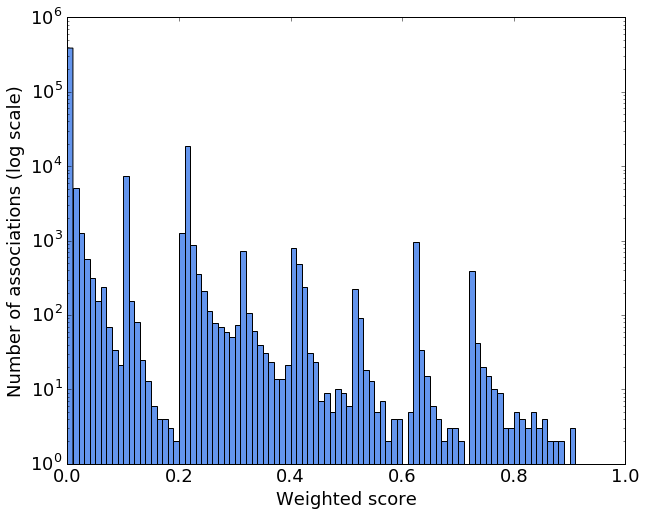

In [4]:
# Visualize distribution of scores among the gene-disease associations listed

bins = np.arange(0,1.01,0.01)
color = 'CornflowerBlue'


plt.rc('font', size='18')
# plt.ioff()

fig, ax = plt.subplots(1, figsize=(10,8))
ax.set_xlabel('Weighted score')
ax.set_ylabel('Number of associations (log scale)')
ax.set_yscale("log", nonposy='clip')
_,_,_ = plt.hist(df['score'], bins=bins, color=color)

plt.show()

### Notes

The data is heavily skewed toward the lower scores with median well below the mean and the majority of values below the midpoint of the score range.

Thus the population of scores near the top of the range is low, indicating a very small percentage of scores suggest a strong gene-disease link.

In [5]:
# Mean and median score of all disease

print('Mean score:', '{:.5f}'.format(df['score'].mean()))
print('Median score:', '{:.5f}'.format(df['score'].median()))

sermid = df['score']>0.5   # return boolean series so sum to get count of True values
print('Percentage of data above score range midpoint (0.5):', '{:.2%}'.format(sermid.sum()/df['score'].count()))

Mean score: 0.01932
Median score: 0.00057
Percentage of data above score range midpoint (0.5): 0.45%


## Refine data

Express data in terms of number of genes per disease and score for each association.

Diseases with higher scores and fewer genes are ideal.

In [6]:
# Number of genes per disease
dfdis = df[['diseaseName','geneSymbol']].groupby(['diseaseName'], sort=False).count()
dfdis.columns = ['Number of genes']
dfdis.sort_values('Number of genes', ascending=False, inplace=True)

print('Number of total diseases in database:', dfdis.shape[0])

# Move diseaseName to column and reset index to integers
dfdis.reset_index(level=0, inplace=True)
dfdis.head()

Number of total diseases in database: 14586


,diseaseName,Number of genes
0,"NEOPLASM, MALIGNANT",5689
1,Primary malignant neoplasm,5095
2,Malignant neoplasm breast,4219
3,Breast Carcinoma,3983
4,Carcinogenesis,3398


In [7]:
# Isolate gene and disease data to be combined with number of genes per disease

# dfscore = df[['diseaseName','score','geneName']].drop_duplicates('diseaseName').set_index('diseaseName')

dfscore = df[['diseaseName','score','geneSymbol','geneName']]

print(dfscore.shape)
dfscore.head()

(429111, 4)


,diseaseName,score,geneSymbol,geneName
0,Hepatolenticular Degeneration,0.972607,ATP7B,"ATPase, Cu++ transporting, beta polypeptide"
1,Obesity,0.940000,MC4R,melanocortin 4 receptor
2,"Diabetes Mellitus, Type 2",0.907216,IRS1,insulin receptor substrate 1
3,Rett Syndrome,0.900000,MECP2,methyl CpG binding protein 2
4,Cystic Fibrosis,0.900000,CFTR,cystic fibrosis transmembrane conductance regu...


In [8]:
# Merge two previous dataframes preserving all duplicate disease names
dfscoredis = pd.merge(dfdis,dfscore,how='outer')
dfscoredis.sort_values('score',ascending=False, inplace=True)

print(dfscoredis.shape)
dfscoredis.head(20)

(429111, 5)


,diseaseName,Number of genes,score,geneSymbol,geneName
354418,Hepatolenticular Degeneration,42,0.972607,ATP7B,"ATPase, Cu++ transporting, beta polypeptide"
83966,Obesity,1693,0.940000,MC4R,melanocortin 4 receptor
80552,"Diabetes Mellitus, Type 2",1716,0.907216,IRS1,insulin receptor substrate 1
202230,Cystic Fibrosis,401,0.900000,CFTR,cystic fibrosis transmembrane conductance regu...
294484,Rett Syndrome,119,0.900000,MECP2,methyl CpG binding protein 2
318589,Creutzfeldt-Jakob Syndrome,79,0.884361,PRNP,prion protein
309558,Fragile X Syndrome,93,0.880361,FMR1,fragile X mental retardation 1
224345,Gastrointestinal Stromal Tumors,302,0.879390,KIT,v-kit Hardy-Zuckerman 4 feline sarcoma viral o...
314124,Familial Mediterranean Fever,86,0.870271,MEFV,Mediterranean fever
351008,Brugada Syndrome,44,0.869105,SCN5A,"sodium channel, voltage gated, type V alpha su..."


## Quality criteria
At this stage, the dataframe contains gene-disease associations with multiple, duplicate `diseaseName` entries.

Next gene disease associations meeting a certain quality threshold will be retained. Specifically, if the gene-disease link has a score above 0.7 and each disease has fewer than 5 linked genes, the association will be retained.

Before further analysis of each of the remaining diseases, a dataframe will be created where diseases with multiple genes will be reduced to a single entry (row).

In [9]:
# Select higher quality data by removing lower scores and high number of genes
dfthresh = dfscoredis.copy()
dfthresh = dfthresh[(dfthresh['Number of genes']<5) & (dfthresh['score']>0.7)]
print('Diseases meeting threshold:', dfthresh.shape[0])

# Generate copy and keep first occurence (the first occurence has the higher score in descending sorted list)
dfunique = dfthresh.copy(deep=False)
dfthresh.sort_values('score', ascending=False, inplace=True)
dfthresh.drop_duplicates(['diseaseName'],keep='first',inplace=True)

# Check values removed
dfrem = dfunique.drop(dfthresh.index)

print('')
print('Disease with duplicates:')
print(dfrem['diseaseName'].tolist())

print('')
print('Total unique diseases meeting threshold:', dfthresh.shape[0])
dfthresh.head()

# Convert conditions to lower case and save CSV
dfthresh['diseaseName']=dfthresh['diseaseName'].str.lower()
dfthresh.to_csv('dfall.csv', index=False)

Diseases meeting threshold: 277

Disease with duplicates:
['Sitosterolemia', 'Myasthenic syndrome, congenital, type Id']

Total unique diseases meeting threshold: 275


## Disease aliases
In order to find the disease category and incidence rate, known aliases of each disease must be determined. This data comes from an NIH Genetics database (<a href="http://ghr.nlm.nih.gov/">http://ghr.nlm.nih.gov/</a>). 

Rather than scrape the server for each disease, the information on each disease category page will be downloaded with the requests library and a local database constructed.

In [10]:
conditionurl = 'http://ghr.nlm.nih.gov/BrowseConditions'

# Request content from web page
result = requests.get(conditionurl)

# Set as Beautiful Soup Object
soup = BeautifulSoup(result.content, "lxml")

# Condition links are located in the div element with class 'nmx'

links = [[link.contents[0],link.get('href')] for link in soup.select("[class==nmx] a")]
dfcatlinks = pd.DataFrame(links, columns=['Category','Relative Link'])
dfcatlinks.to_csv('BrowseConditions.csv', index=False)

dfcatlinks

,Category,Relative Link
0,Blood/lymphatic system,/conditionCategory/blood-lymphatic-system
1,"Bones, muscles, and connective tissues",/conditionCategory/bones-muscles-and-connectiv...
2,Brain and nervous system,/conditionCategory/brain-and-nervous-system
3,Cancers,/conditionCategory/cancers
4,Digestive system,/conditionCategory/digestive-system
5,"Ear, nose, and throat",/conditionCategory/ear-nose-and-throat
6,Endocrine system (hormones),/conditionCategory/endocrine-system-hormones
7,Eyes and vision,/conditionCategory/eyes-and-vision
8,"Food, nutrition, and metabolism",/conditionCategory/food-nutrition-and-metabolism
9,Heart and circulation,/conditionCategory/heart-and-circulation


In [11]:
# Scrape condition category page for conditions and known aliases then save to a dataframe
baseurl = 'http://ghr.nlm.nih.gov'

# Split link into disease and alias
# Condition,Alias = re.split(' <em>see</em> ')

# Request content from web page and set beautiful soup object
condlinks = []
ptrn = re.compile('^\s')

for i in dfcatlinks.index:
    categoryurl = baseurl+dfcatlinks.iloc[i].get('Relative Link')
    result = requests.get(categoryurl)
    soup = BeautifulSoup(result.content, "lxml")
    pageprimary = soup.select("[class==page-primary] li")
    
    items = []
    
    # Save every category, alias, and link for every condition in NIH database
    for li in pageprimary:
        items.append([dfcatlinks.iloc[i].get('Category'), li.a.contents[0], ptrn.sub('',li.contents[-1]), li.a.get('href')])

    condlinks.extend(items)

In [12]:
# Convert conditions and aliases to lower case and save CSV
dfcondlinks = pd.DataFrame(condlinks, columns=['Category','Condition','Alias','Relative Link'])

dfcondlinks['Condition']=dfcondlinks['Condition'].str.lower()
dfcondlinks['Alias']=dfcondlinks['Alias'].str.lower()

dfcondlinks.to_csv('ConditionAlias.csv', index=False)
dfcondlinks.head()

,Category,Condition,Alias,Relative Link
0,Blood/lymphatic system,5-oxoprolinemia,glutathione synthetase deficiency,/condition/glutathione-synthetase-deficiency
1,Blood/lymphatic system,5-oxoprolinuria,glutathione synthetase deficiency,/condition/glutathione-synthetase-deficiency
2,Blood/lymphatic system,5q minus syndrome,,/condition/5q-minus-syndrome
3,Blood/lymphatic system,8p11 myeloproliferative syndrome,,/condition/8p11-myeloproliferative-syndrome
4,Blood/lymphatic system,11q deletion disorder,jacobsen syndrome,/condition/jacobsen-syndrome


In [13]:
len(dfcondlinks.index)

10145

## Identify category and relative link for each disease

In [14]:
# For list of conditions in dfall.csv find the ConditionAlias.csv dataset 
# then save the category and relative link in dfall.csv.

dfall = pd.read_csv('dfall.csv')
dfcondlinks = pd.read_csv('ConditionAlias.csv')
dfall['relurl']=''
dfall['category']=''

for disease in dfall['diseaseName']:
    if disease in dfcondlinks['Condition'].values:
        link = dfcondlinks['Relative Link'][dfcondlinks['Condition']==disease].iloc[0]
        category = dfcondlinks['Category'][dfcondlinks['Condition']==disease].iloc[0]
    elif disease in dfcondlinks['Alias'].values:
        link = dfcondlinks['Relative Link'][dfcondlinks['Alias']==disease].iloc[0]
        category = dfcondlinks['Category'][dfcondlinks['Alias']==disease].iloc[0]
    else:
        link = np.nan
        category = np.nan
    dfall.set_value(dfall.index[dfall['diseaseName']==disease][0],'relurl', link)
    dfall.set_value(dfall.index[dfall['diseaseName']==disease][0],'category', category)
    
dfall.to_csv('dfall.csv', index=False)
dfall.tail(10)

,diseaseName,Number of genes,score,geneSymbol,geneName,relurl,category
265,sitosterolemia,2,0.72,ABCG5,"ATP-binding cassette, sub-family G (WHITE), me...",/condition/sitosterolemia,Blood/lymphatic system
266,"parkinson disease 1, autosomal dominant",1,0.72,SNCA,"synuclein, alpha (non A4 component of amyloid ...",NaN,NaN
267,"deafness, autosomal dominant 13",1,0.72,COL11A2,"collagen, type XI, alpha 2",NaN,NaN
268,"cardiomyopathy, dilated, 1g",1,0.72,TTN,titin,NaN,NaN
269,focal segmental glomerulosclerosis 2,1,0.72,TRPC6,"transient receptor potential cation channel, s...",NaN,NaN
270,joubert syndrome 6,1,0.72,TMEM67,transmembrane protein 67,NaN,NaN
271,"charcot-marie-tooth disease, type 2b1",1,0.72,LMNA,lamin A/C,NaN,NaN
272,"deafness, autosomal dominant 25",2,0.72,SLC17A8,solute carrier family 17 (vesicular glutamate ...,NaN,NaN
273,"usher syndrome, type ig",2,0.72,USH1G,Usher syndrome 1G (autosomal recessive),NaN,NaN
274,muscular dystrophy-dystroglycanopathy (congeni...,1,0.72,LARGE,like-glycosyltransferase,NaN,NaN


___
## Visualize results

Load in previously saved data from csv ('dfall.csv') so that above cells don't need to be rerun.

In [15]:
# Generate plot data
dfall = pd.read_csv('dfall.csv')
dfall.fillna(value='Not Available', inplace=True)
yy = dfall['Number of genes']
xx = dfall['score']

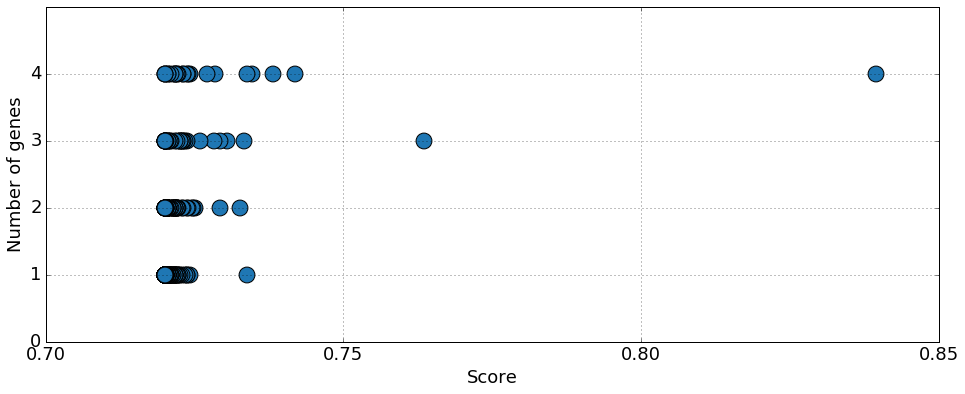

In [16]:
# Generate colors for graphs
colorseq = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
            '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
            '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
            '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']

plt.rc('font', size='18')


fig, ax = plt.subplots(1, figsize=(16,6))
ax.scatter(xx,yy, c=colorseq[0], s=250, alpha=1)
ax.yaxis.set_ticks(np.arange(0,5,1))
ax.set_ylim(0,5)
ax.xaxis.set_ticks(np.arange(0.7,0.9,0.05))
ax.set_xlim(0.7, 0.85)
ax.set_xlabel('Score')
ax.set_ylabel('Number of genes')
# ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

plt.grid(True)

plt.show()

## Refine data visualization

In general points in the bottom right of the rudimentary graph above are the ideal targets for drug development. Two points stand out in particular 'Canavan disease' and 'Cleidocranial Dysplasia'.

To get more detailed information, the graph will be refocused on the clustered points between scores of 0.70 and 0.75. Also incidence rate information and disease category will be inserted.

In [17]:
dfall.head()

,diseaseName,Number of genes,score,geneSymbol,geneName,relurl,category
0,canavan disease,4,0.839553,ASPA,aspartoacylase,/condition/canavan-disease,Brain and nervous system
1,cleidocranial dysplasia,3,0.763477,RUNX2,runt-related transcription factor 2,/condition/cleidocranial-dysplasia,"Bones, muscles, and connective tissues"
2,glycogen storage disease type iib,4,0.741969,LAMP2,lysosomal-associated membrane protein 2,/condition/danon-disease,"Bones, muscles, and connective tissues"
3,primary hyperoxaluria type 1,4,0.738144,AGXT,alanine-glyoxylate aminotransferase,Not Available,Not Available
4,mucopolysaccharidosis vii,4,0.734742,GUSB,"glucuronidase, beta",Not Available,Not Available


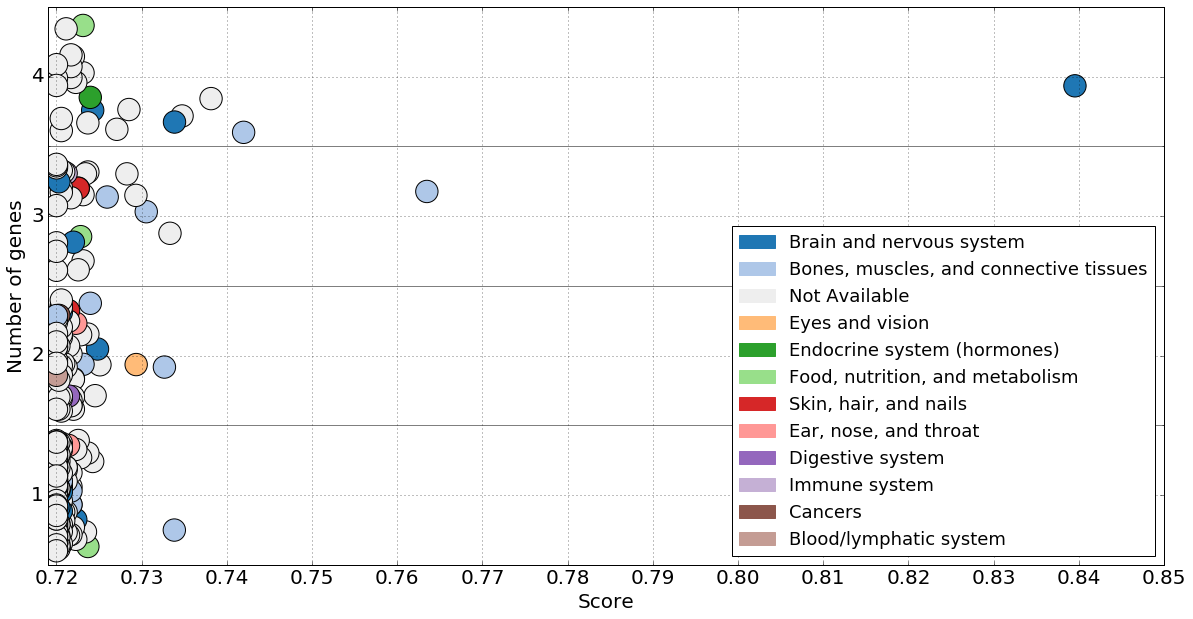

In [18]:
# Zoom in on clustered regions, larger points have identified disease
# Also color code data points based on disease category

ptsize = 250
areaidx = 1 # areaidx = incididx
areas = (areaidx*ptsize)+ptsize
# colors = [colorseq[1-b] for b in incididx]

uniqcat = dfall['category'].unique()
catclr = dict(zip(uniqcat.tolist(),colorseq[:len(uniqcat)]))
catclr['Not Available'] = '#eeeeee'
# print(catclr)

plt.rc('font', size='20')

# Scatter points for better readability
np.random.seed(1)
rndm = (np.random.random(yy.shape) - 0.5) * 0.8

# Assign colors for data points
colors = [catclr[cat] for cat in dfall['category']]

# Create plot
fig, ax = plt.subplots(1, figsize=(20,10))
ax.scatter(xx,yy+rndm, c=colors, s=areas, alpha=1)
ax.yaxis.set_ticks(np.arange(0,5,1))
ax.set_ylim(0.5,4.5)
ax.xaxis.set_ticks(np.arange(0.7,0.85,0.01))
ax.set_xlim(0.719, 0.85)
ax.set_xlabel('Score')
ax.set_ylabel('Number of genes')
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))

# Create legend
patches = []
for lbl in uniqcat:
    patches.append(mpatches.Patch(color=catclr[lbl], label=lbl))
ax.legend(handles=patches, loc='lower right', fontsize='18')

ax.grid(True, which='both')
ax.grid(color='k', linestyle='solid', which='minor', axis='y', linewidth=0.5)

# ax.title()


plt.show()

## Repeat plot but with Bokeh
Bokeh has <b>zoom</b>, <b>resize</b> and <b>mouse-over</b> functionality built-in.

In [19]:
from bokeh.plotting import figure, output_notebook, save, show, ColumnDataSource, output_file
from bokeh.models import HoverTool
from collections import OrderedDict


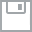
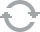
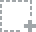
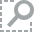
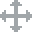
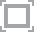
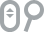
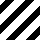
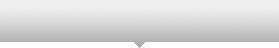
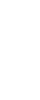
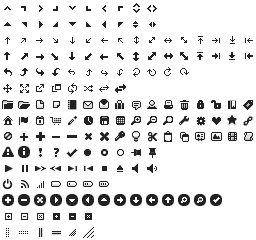
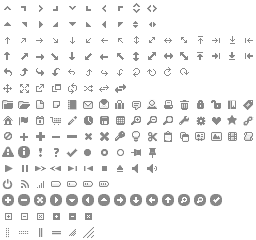
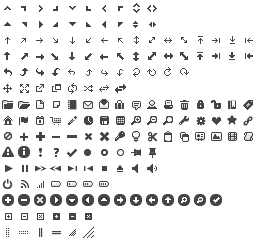
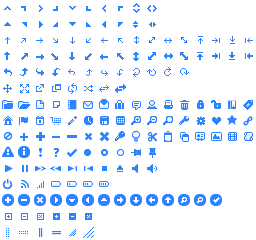
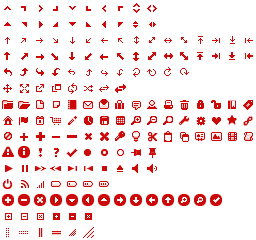
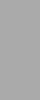
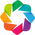
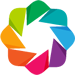

In [20]:
output_notebook()

In [25]:
source = ColumnDataSource(data=dict(x=xx, y=yy, desc=dfall['diseaseName']))

hover = HoverTool(tooltips=[("Disease", "@desc"), ("Score", "$x"), ("Number of Genes", "$y")])

# toollist = "pan,box_zoom,reset,save,resize,hover"

dfall['color'] = dfall['category'].map(lambda x: catclr[x])

p = figure(title = "Gene Disease", tools='hover', plot_width=950, plot_height=500)
p.xaxis.axis_label = 'Score'
p.yaxis.axis_label = 'Number of Genes'

p.scatter(xx,yy, color=dfall["color"], fill_alpha=0.5, size=10, source=source)

show(p)


# output_file("toolbar.html")

# source = ColumnDataSource(
#         data=dict(
#             x=[1, 2, 3, 4, 5],
#             y=[2, 5, 8, 2, 7],
#             desc=['A', 'b', 'C', 'd', 'E'],
#             imgs = [
#                 'http://bokeh.pydata.org/static/snake.jpg',
#                 'http://bokeh.pydata.org/static/snake2.png',
#                 'http://bokeh.pydata.org/static/snake3D.png',
#                 'http://bokeh.pydata.org/static/snake4_TheRevenge.png',
#                 'http://bokeh.pydata.org/static/snakebite.jpg'
#             ]
#         )
#     )

# hover = HoverTool(
#         tooltips="""
#         <div>
#             <div>
#                 <img
#                     src="@imgs" height="42" alt="@imgs" width="42"
#                     style="float: left; margin: 0px 15px 15px 0px;"
#                     border="2"
#                 ></img>
#             </div>
#             <div>
#                 <span style="font-size: 17px; font-weight: bold;">@desc</span>
#                 <span style="font-size: 15px; color: #966;">[$index]</span>
#             </div>
#             <div>
#                 <span style="font-size: 15px;">Location</span>
#                 <span style="font-size: 10px; color: #696;">($x, $y)</span>
#             </div>
#         </div>
#         """
#     )

# p = figure(plot_width=400, plot_height=400, tools=[hover],
#            title="Mouse over the dots")

# p.circle('x', 'y', size=20, source=source)

# show(p)

## Distribution of remaining scores

It is possible to objectively determine outliers that represent good candidates for drug development. This can be done by assuming the data fits into half a normal distribution then developing a confidence interval where data points that exceed this value (i.e., in the tail) are gene-disease associations with a strong score.

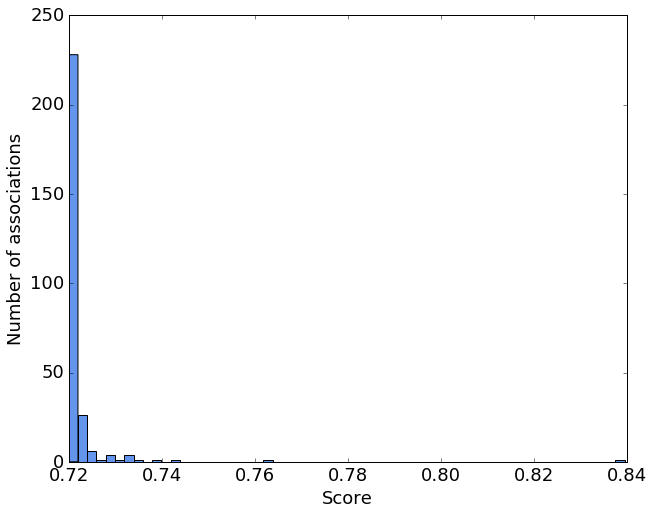

In [22]:
# Visualize distribution of scores among the gene-disease associations listed

# bins = np.arange(0.7,0.81,0.01)
color = 'CornflowerBlue'


plt.rc('font', size='18')
# plt.ioff()

fig, ax = plt.subplots(1, figsize=(10,8))
ax.set_xlabel('Score')
ax.set_ylabel('Number of associations')
# ax.set_yscale("log", nonposy='clip')
_,_,_ = plt.hist(dfall['score'], bins=60, color=color)

plt.show()

## Discussion

Many disease categories are not identified due to the existence of multiple names for each in the database. It is necessary to search through all of the individual condition pages to identify the appropriate aliases.

Currently, the size of the data point for each gene-disease link indicates only if the incidence rate was found in the NIH database. Once more incidence rate data is collected, the size will reflect the actual disease incidence.

Additional work is needed to add the remaining disease categories and also include a mouseover animation that will identify the gene-disease link represented by each data point.

# Go to phase II notebook

https://github.com/dbricare/datainc/blob/master/agingdata.ipynb